# Max-Cut Implementation on Qiskit

Some sections of the code have been obtained from the contents on: 

In [122]:
# Necessary Libraries for program execution
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import qiskit_ibm_runtime.accounts.storage
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import Parameter, ParameterVector
from scipy.optimize import minimize
import plotly.graph_objects as go

## 1. Parameter Selection
Choose the desired parameters to configure the creation of a Max-Cut Algorithm
- Seed for the random value generation
- n for the total number of nodes in the problem
- p for the probability of generating and edge between two nodes
- minimum_weight for the minimum edge weight
- maximum_weight for the maximum edge weight

In [123]:
import os

# Disable the current account
QiskitRuntimeService.delete_account()


# Delete the local file storing the token
config_path = os.path.expanduser("~/.qiskit/qiskit-ibm.json")
if os.path.exists(config_path):
    os.remove(config_path)

# Credentials Login
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.delete_account()
gmail_token = 'ec8c90467f71da5bb79c7192307ad7e1adeb07cbffe3ffc4d9d3c9dfc61700ac672e478f753e611ba1dba599bcfce14ea118ab39e4a48793c9709f5706c0d85c'
token = "66d3963017c86c91e3a9843632e2c1274db80cfa33ebe82e99de059ce94c14d9999885d7d9391de1c162506c3786cba29658c538d01c141c231296d52d166f81"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)


In [124]:
seed = 123
n = 7
p = 0.5
minimum_weight = 1
maximum_weight = 10

In [125]:
def create_random_instance(n: int, low: int = 0, high: int = 100, p: float = 1, seed: int = None) -> nx.Graph:
    """Create a random instance of a Graph with n nodes and p probability of having weighted edges between nodes.
    Args:
        n: the number of nodes.
        low: The minimum value for the coordinate of a node.
        high: The maximum value for the coordinate of a node.
        seed: the seed for the random values.
        p: the probability that the node is visited.

    Returns:
         A Graph instance created from the input information
    """
    if seed:
        algorithm_globals.random_seed = seed
        random.seed(seed)
    #coord = algorithm_globals.random.uniform(low, high, (n, 2))
    #pos = {i: (coord_[0], coord_[1]) for i, coord_ in enumerate(coord)}
    gen_graph = nx.erdos_renyi_graph(n, p, seed=seed)
    for i, j in gen_graph.edges:
        gen_graph.edges[i, j]["weight"] = random.randint(low, high)
    return gen_graph

## 2. Create a Graph

[(0, 1, {'weight': 1}), (0, 2, {'weight': 5}), (0, 3, {'weight': 2}), (0, 4, {'weight': 7}), (0, 6, {'weight': 5}), (1, 3, {'weight': 2}), (1, 5, {'weight': 1}), (1, 6, {'weight': 7}), (2, 3, {'weight': 9}), (2, 4, {'weight': 9}), (2, 5, {'weight': 6}), (2, 6, {'weight': 6}), (3, 4, {'weight': 1}), (3, 6, {'weight': 3}), (4, 5, {'weight': 3}), (4, 6, {'weight': 6})]


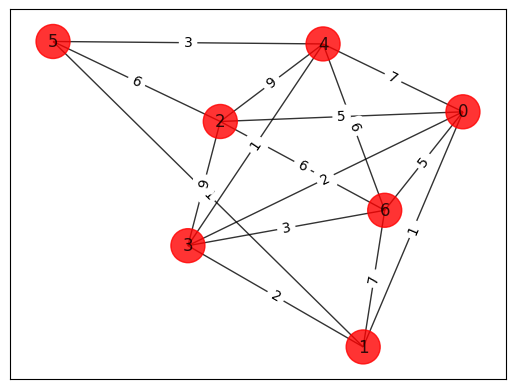

In [126]:
G = create_random_instance(n=n, low=minimum_weight, high=maximum_weight, p=p, seed=seed)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)
print(G.edges.data())

### Brute force approach
Try all possible $2^n$ combinations. For $n = 4$, as in this example, one deals with only 16 combinations, but for n = 1000, one has 1.071509e+30 combinations, which is impractical to deal with by using a brute force approach. 

case = [0, 0, 0, 0, 0, 0, 0] cost = 0
case = [1, 0, 0, 0, 0, 0, 0] cost = 20
case = [0, 1, 0, 0, 0, 0, 0] cost = 10
case = [1, 1, 0, 0, 0, 0, 0] cost = 29
case = [0, 0, 1, 0, 0, 0, 0] cost = 30
case = [1, 0, 1, 0, 0, 0, 0] cost = 45
case = [0, 1, 1, 0, 0, 0, 0] cost = 40
case = [1, 1, 1, 0, 0, 0, 0] cost = 54
case = [0, 0, 0, 1, 0, 0, 0] cost = 4
case = [1, 0, 0, 1, 0, 0, 0] cost = 22
case = [0, 1, 0, 1, 0, 0, 0] cost = 12
case = [1, 1, 0, 1, 0, 0, 0] cost = 29
case = [0, 0, 1, 1, 0, 0, 0] cost = 25
case = [1, 0, 1, 1, 0, 0, 0] cost = 38
case = [0, 1, 1, 1, 0, 0, 0] cost = 33
case = [1, 1, 1, 1, 0, 0, 0] cost = 45
case = [0, 0, 0, 0, 1, 0, 0] cost = 9
case = [1, 0, 0, 0, 1, 0, 0] cost = 22
case = [0, 1, 0, 0, 1, 0, 0] cost = 19
case = [1, 1, 0, 0, 1, 0, 0] cost = 31
case = [0, 0, 1, 0, 1, 0, 0] cost = 30
case = [1, 0, 1, 0, 1, 0, 0] cost = 38
case = [0, 1, 1, 0, 1, 0, 0] cost = 40
case = [1, 1, 1, 0, 1, 0, 0] cost = 47
case = [0, 0, 0, 1, 1, 0, 0] cost = 12
case = [1, 0, 0, 1, 1, 0, 0]

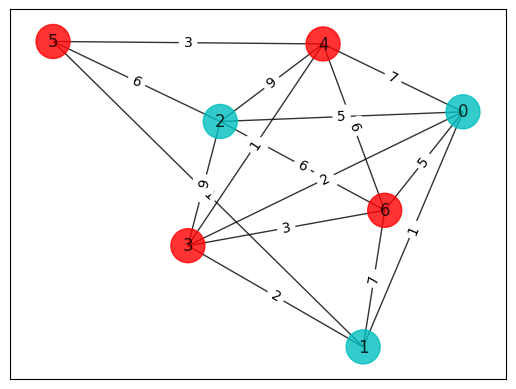

In [127]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i, j in G.edges():
        cost = cost + G.edges()[i, j]['weight'] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

## 3. Define the Quadratic Program

Qiskit optimization provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.


In [128]:
max_cut = Maxcut(graph=G)
qp = max_cut.to_quadratic_program()
print(qp.objective.quadratic.to_dict().items())
print(qp.prettyprint())

dict_items([((0, 1), -2.0), ((0, 2), -10.0), ((0, 3), -4.0), ((0, 4), -14.0), ((0, 6), -10.0), ((1, 3), -4.0), ((1, 5), -2.0), ((1, 6), -14.0), ((2, 3), -18.0), ((2, 4), -18.0), ((2, 5), -12.0), ((2, 6), -12.0), ((3, 4), -2.0), ((3, 6), -6.0), ((4, 5), -6.0), ((4, 6), -12.0)])
Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 10*x_0*x_2 - 4*x_0*x_3 - 14*x_0*x_4 - 10*x_0*x_6 - 4*x_1*x_3
  - 2*x_1*x_5 - 14*x_1*x_6 - 18*x_2*x_3 - 18*x_2*x_4 - 12*x_2*x_5 - 12*x_2*x_6
  - 2*x_3*x_4 - 6*x_3*x_6 - 6*x_4*x_5 - 12*x_4*x_6 + 20*x_0 + 11*x_1 + 35*x_2
  + 17*x_3 + 26*x_4 + 10*x_5 + 27*x_6

Subject to
  No constraints

  Binary variables (7)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6



### 4. Convert to QUBO

In [129]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print("QUBO:", qubo.prettyprint())

QUBO: Problem name: Max-cut

Minimize
  2*x_0*x_1 + 10*x_0*x_2 + 4*x_0*x_3 + 14*x_0*x_4 + 10*x_0*x_6 + 4*x_1*x_3
  + 2*x_1*x_5 + 14*x_1*x_6 + 18*x_2*x_3 + 18*x_2*x_4 + 12*x_2*x_5 + 12*x_2*x_6
  + 2*x_3*x_4 + 6*x_3*x_6 + 6*x_4*x_5 + 12*x_4*x_6 - 20*x_0 - 11*x_1 - 35*x_2
  - 17*x_3 - 26*x_4 - 10*x_5 - 27*x_6

Subject to
  No constraints

  Binary variables (7)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6



In [130]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -36.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIZZ', 'IIIIZIZ', 'IIIZIIZ', 'IIZIIIZ', 'ZIIIIIZ', 'IIIZIZI', 'IZIIIZI', 'ZIIIIZI', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIIZII', 'IIZZIII', 'ZIIZIII', 'IZZIIII', 'ZIZIIII'],
              coeffs=[0.5+0.j, 2.5+0.j, 1. +0.j, 3.5+0.j, 2.5+0.j, 1. +0.j, 0.5+0.j, 3.5+0.j,
 4.5+0.j, 4.5+0.j, 3. +0.j, 3. +0.j, 0.5+0.j, 1.5+0.j, 1.5+0.j, 3. +0.j])


In [189]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 54.0
variable values: x_0=1.0, x_1=0.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=1.0, x_6=1.0
status: SUCCESS


Since the problem was cast to a minimization problem, the solution of $-4$ corresponds to the optimum.

## Running on Quantum Computer
Configuration of the Service and Backend

In [190]:
service = QiskitRuntimeService(channel="ibm_cloud")
# To execute in real hardware, set this variable to true!
RUN_MODE = False

if RUN_MODE:
    # To run on hardware, select the backend with the fewest number of jobs in the queue
    backend = service.least_busy(operational=True, simulator=False)
else:
    real_backend = service.backend("ibm_brisbane")
    backend = AerSimulator.from_backend(real_backend)

In [191]:
# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 100000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 100000
sampler.options.dynamical_decoupling.enable = True

C:\Users\guill\PycharmProjects\qiskitTesting\.venv\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning:

Session is not supported in local testing mode or when using a simulator.



Cost Function Determination

In [192]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

### Optimize problem for Quantum Execution
To reduce the total job execution time, V2 primitives only accept circuits (ansatz) and observables (Hamiltonian) that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).

### Adapt to QUBO

In [193]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print("QUBO:", qubo.prettyprint())
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

QUBO: Problem name: Max-cut

Minimize
  2*x_0*x_1 + 10*x_0*x_2 + 4*x_0*x_3 + 14*x_0*x_4 + 10*x_0*x_6 + 4*x_1*x_3
  + 2*x_1*x_5 + 14*x_1*x_6 + 18*x_2*x_3 + 18*x_2*x_4 + 12*x_2*x_5 + 12*x_2*x_6
  + 2*x_3*x_4 + 6*x_3*x_6 + 6*x_4*x_5 + 12*x_4*x_6 - 20*x_0 - 11*x_1 - 35*x_2
  - 17*x_3 - 26*x_4 - 10*x_5 - 27*x_6

Subject to
  No constraints

  Binary variables (7)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6

Offset: -36.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIZZ', 'IIIIZIZ', 'IIIZIIZ', 'IIZIIIZ', 'ZIIIIIZ', 'IIIZIZI', 'IZIIIZI', 'ZIIIIZI', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIIZII', 'IIZZIII', 'ZIIZIII', 'IZZIIII', 'ZIZIIII'],
              coeffs=[0.5+0.j, 2.5+0.j, 1. +0.j, 3.5+0.j, 2.5+0.j, 1. +0.j, 0.5+0.j, 3.5+0.j,
 4.5+0.j, 4.5+0.j, 3. +0.j, 3. +0.j, 0.5+0.j, 1.5+0.j, 1.5+0.j, 3. +0.j])


## 5. Create QAOA Circuit

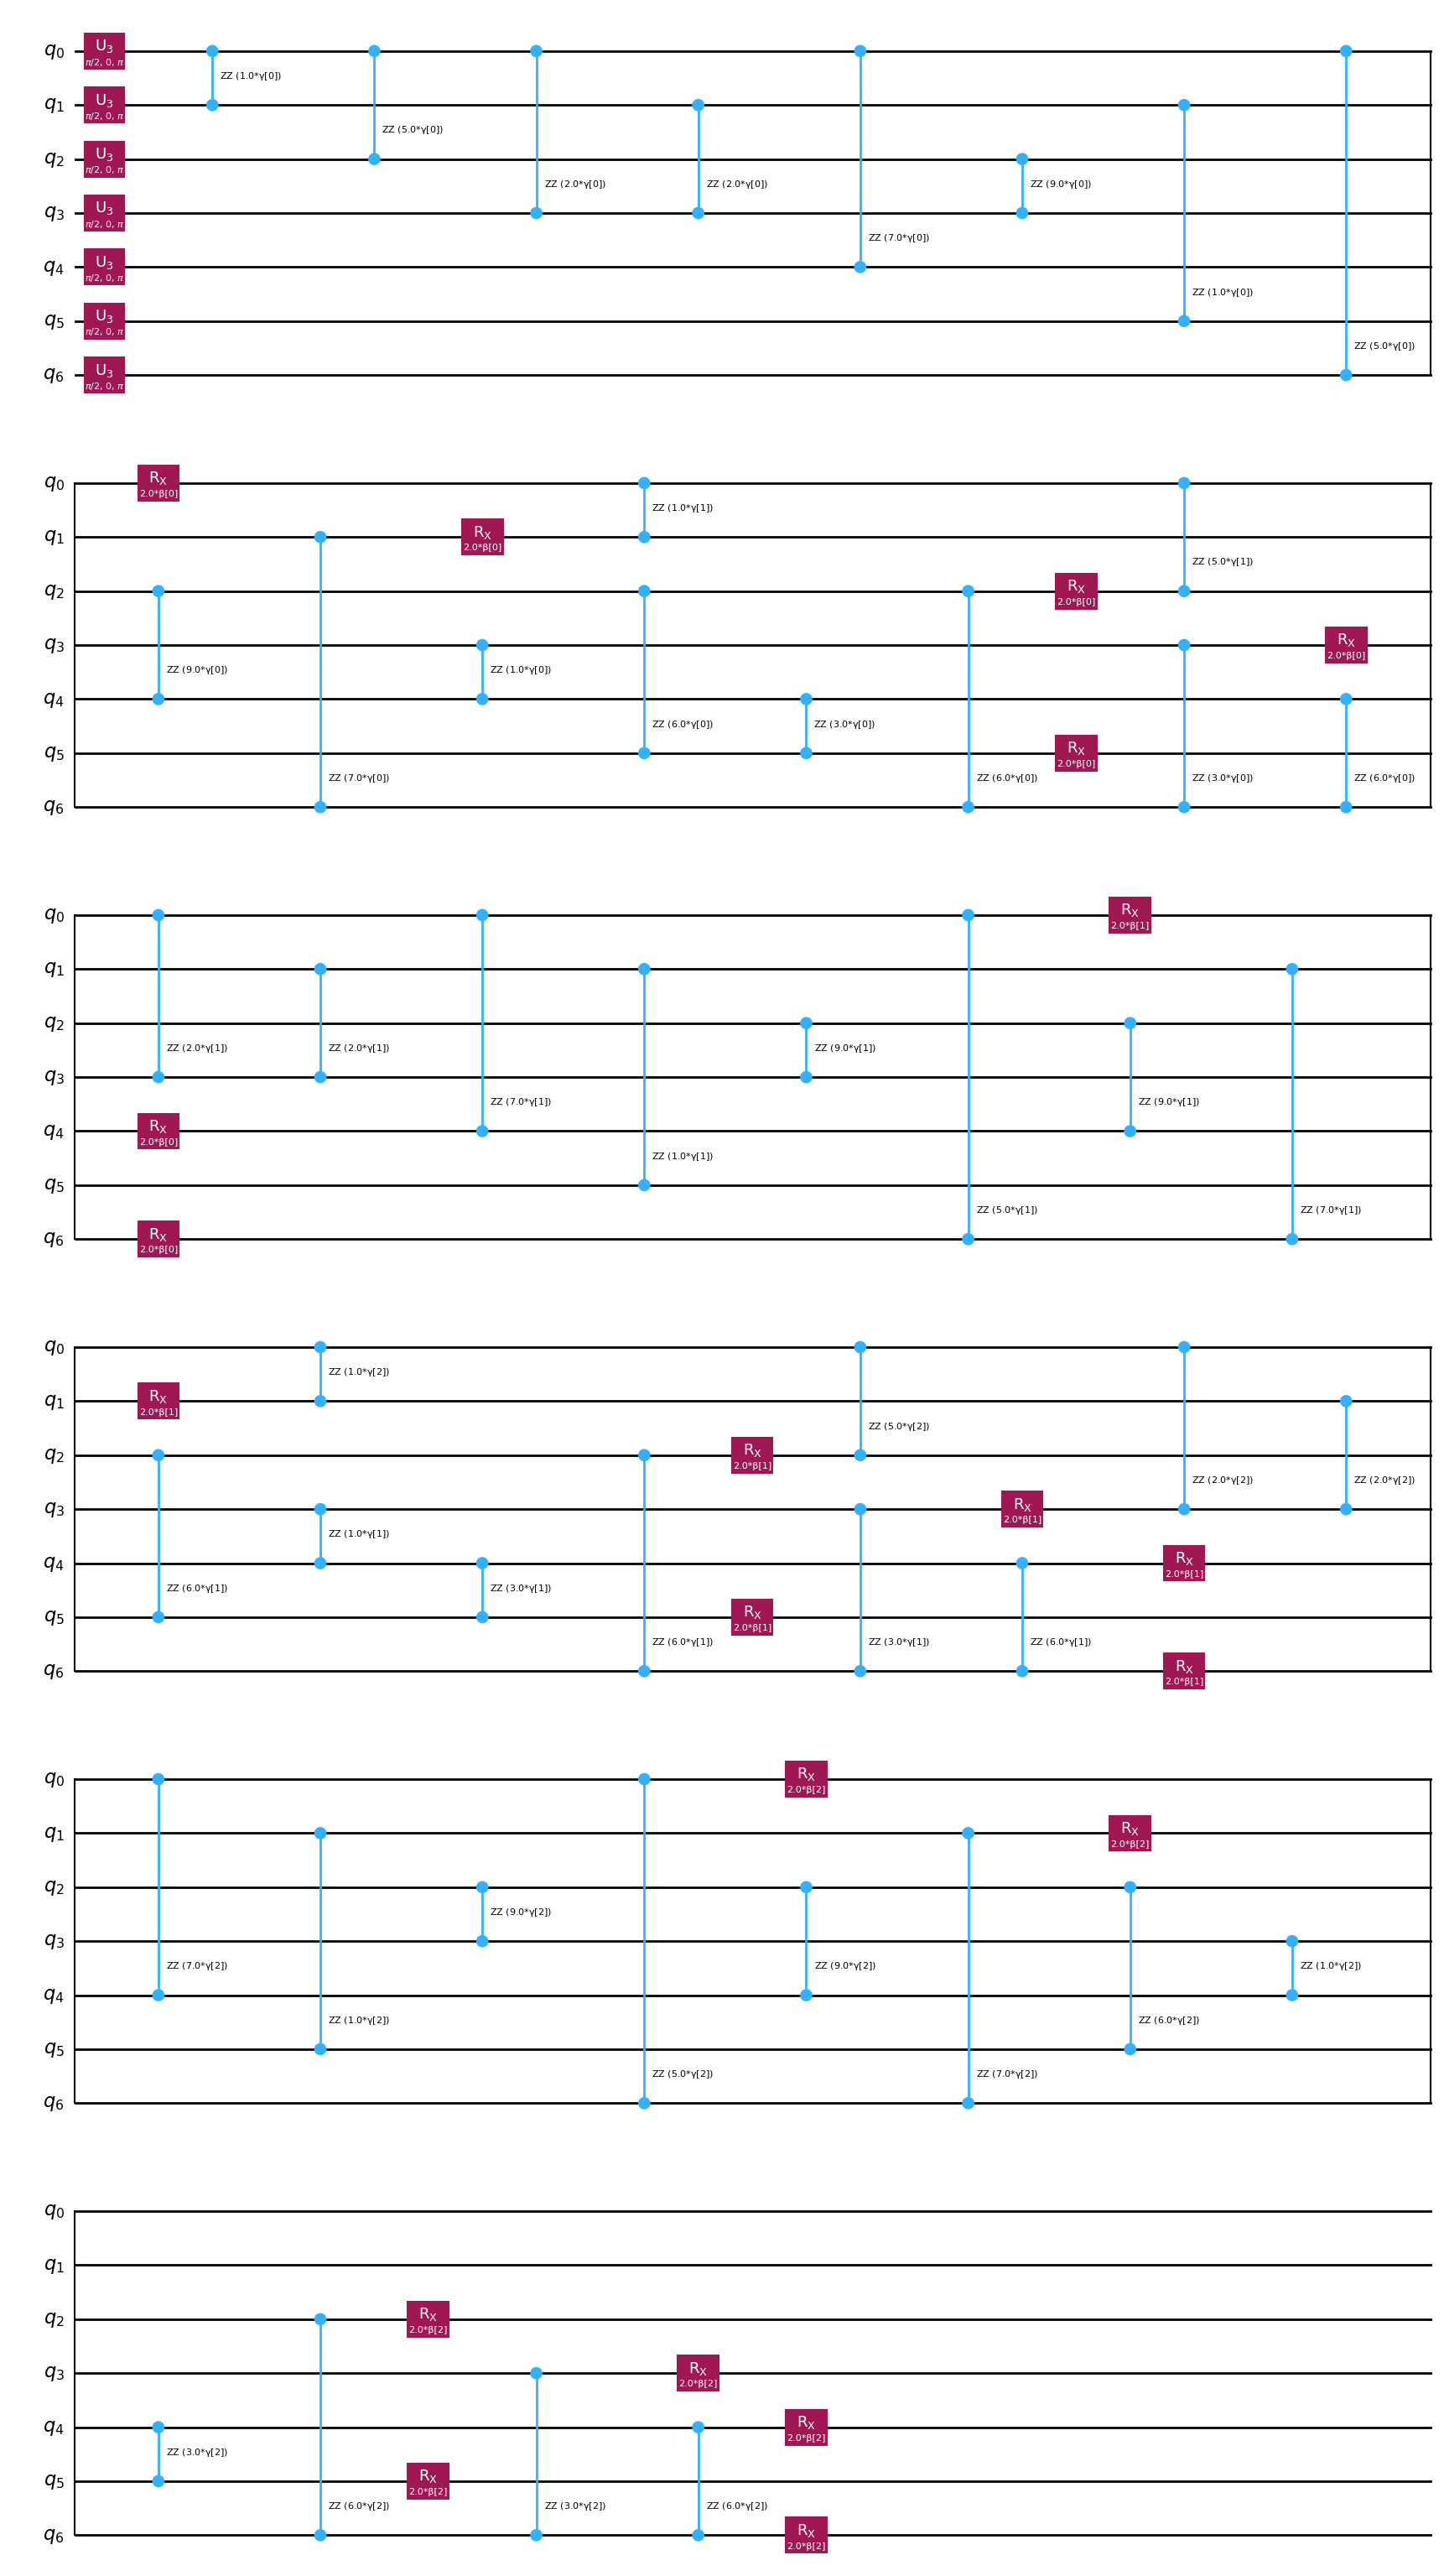

In [194]:
p = 3

ansatz = QAOAAnsatz(qubitOp, reps=p)
#parameters = [Parameter(f'γ_{i}') for i in range(p)] + [Parameter(f'β_{i}') for i in range(p)]
#ansatz.assign_parameters(parameters, inplace=True)

ansatz.decompose().decompose().decompose().draw(output="mpl", style="iqp")

 # 6. Hardware Execution

### 6.1 Circuit Transpile

### ISA Circuit
We can schedule a series of [`qiskit.transpiler`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize our circuit for a selected backend and make it compatible with the instruction set architecture (ISA) of the backend. This can be easily done using a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

* [`optimization_level`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler_preset#preset-pass-manager-generation): The lowest optimization level just does the bare minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all 2-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.


In [195]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

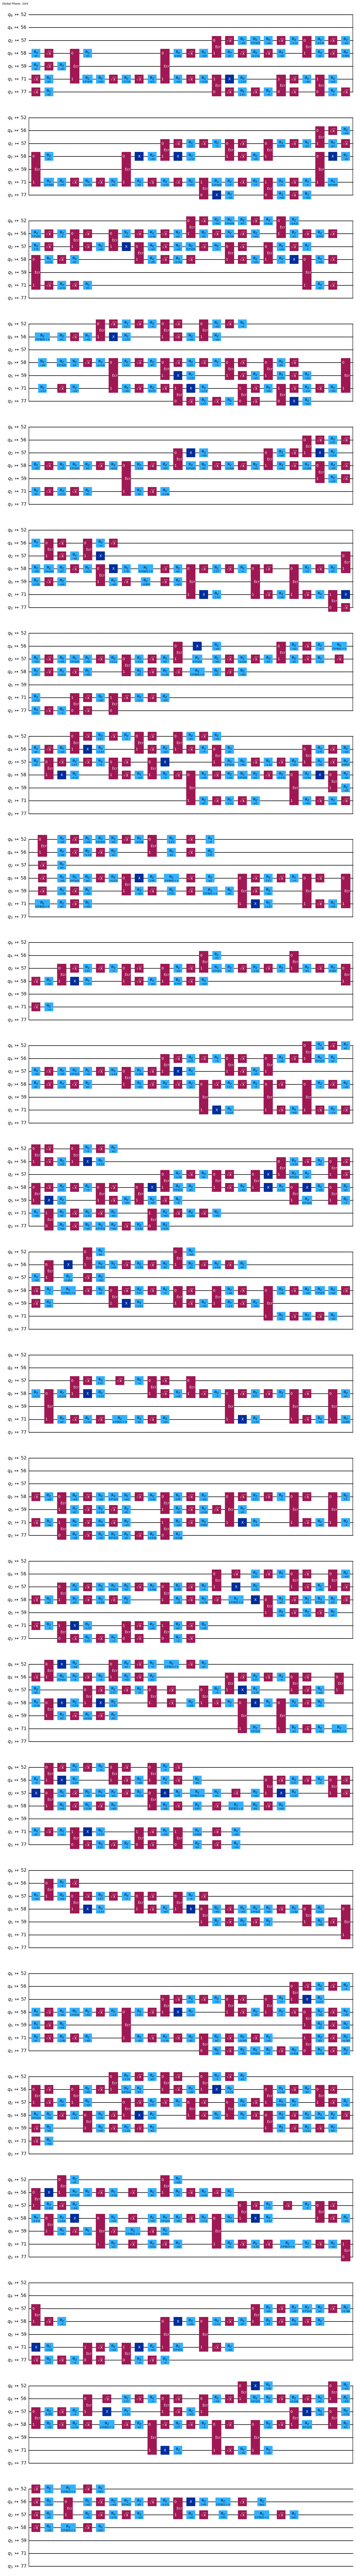

In [196]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables
Similarly, we need to transform the Hamiltonian to make it backend compatible before running jobs with [`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run). We can perform the transformation using the `apply_layout` the method of `SparsePauliOp` object.


In [197]:
hamiltonian, _ = qubo.to_ising()
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIII

### 6.2 Estimating on Hardware
As with an iterative optimization procedure, we now need to define our cost function over which to minimize.  We proceed in an identical manner to the [Variational Quantum Eigensolver tutorial](https://learning.quantum-computing.ibm.com/tutorial/variational-quantum-eigensolver), computing the expectation value of our Hamiltonian with respect to the parameterized ansatz circuit using the [Qiskit Runtime `Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) primitive:


In [203]:
# Set initial random parameters
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
print(x0)

# Minimize routine
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

[1.48281931 3.46494484 0.11876756 3.78480683 4.49810828 1.30053323]


In [204]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.455322265625
       x: [ 2.480e+00  3.544e+00  1.017e+00  4.736e+00  4.462e+00
            1.288e+00]
    nfev: 58
   maxcv: 0.0


## Step 4: Post-process, return result in classical format.
The solution vector of parameter angles (`x`), when plugged into the `ansatz` circuit, yields the graph partitioning that we were looking for.

In [205]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)

# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
#qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

### 6.3 Sampling


In [206]:
from qiskit.visualization import plot_distribution

result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

C:\Users\guill\PycharmProjects\qiskitTesting\.venv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:243: UserWarning:

Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.



## 7. Post-Processing

In [207]:
print(result)

PrimitiveResult([PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=100000, num_bits=7>)))], metadata={})


In [208]:
def calculate_cost_from_bistring(bitstring, graph):
    """
    Calculate the cost of a given bitstring for the Max-Cut problem.

    Args:
        graph (networkx.Graph): The graph for which the Max-Cut cost is calculated.
        bitstring (list[int]): The bitstring representing the cut.

    Returns:
        float: The cost of the given bitstring.
    """
    cost = 0
    for u, v in graph.edges():
        weight = graph.edges()[u, v]["weight"] # default weight is 1 if not specified
        if bitstring[u] != bitstring[v]:
            cost += weight
    return cost

In [209]:
def plot_samples(samples):
    """
    Plots a bar diagram for the samples of a quantum algorithm
    Args:
        samples
    """
    #Sort samples by probability
    samples = sorted(samples.items(), key=lambda kv: kv[1])
    
    # Reinterpret the bitstrings back to the original layout
    bitstrings = []
    for sample in samples:
        vars = []
        # Invert the bitstring because the results are inverted!
        for char in sample[0][::-1]:
            vars.append(int(char))
        bitstrings.append("".join(map(str, map(int, qp2qubo.interpret(vars).tolist()))))
    
    #Get list of probabilities, function values and bitstrings
    probabilities = [sample[1] for sample in samples]
    
    # Interpret the bitstrings back to the original shape
    values = [calculate_cost_from_bistring(bitstring, G) for bitstring in bitstrings]
    
    #Plot bar diagram for frequency
    sample_plot = go.Bar(x = bitstrings, y = probabilities, marker=dict(color=values, colorscale = 'plasma',colorbar=dict(title='Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
    fig.show()
    
    # Group bitstrings
    unique_bitstrings = []
    total_probs = []
    unique_values = []
    for index, bit_string in enumerate(bitstrings): 
        if bit_string not in unique_bitstrings: 
            unique_bitstrings.append(bit_string)
            unique_values.append(values[index])
            total_probs.append(0)
        total_probs[unique_bitstrings.index(bit_string)] += probabilities[index]
        
    #print (unique_bitstrings, total_probs, unique_values)
    #Plot bar diagram for cost
    sample_plot = go.Bar(x = unique_bitstrings, y = total_probs, marker=dict(color=unique_values, colorscale = 'solar',colorbar=dict(title='Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
    fig.show()

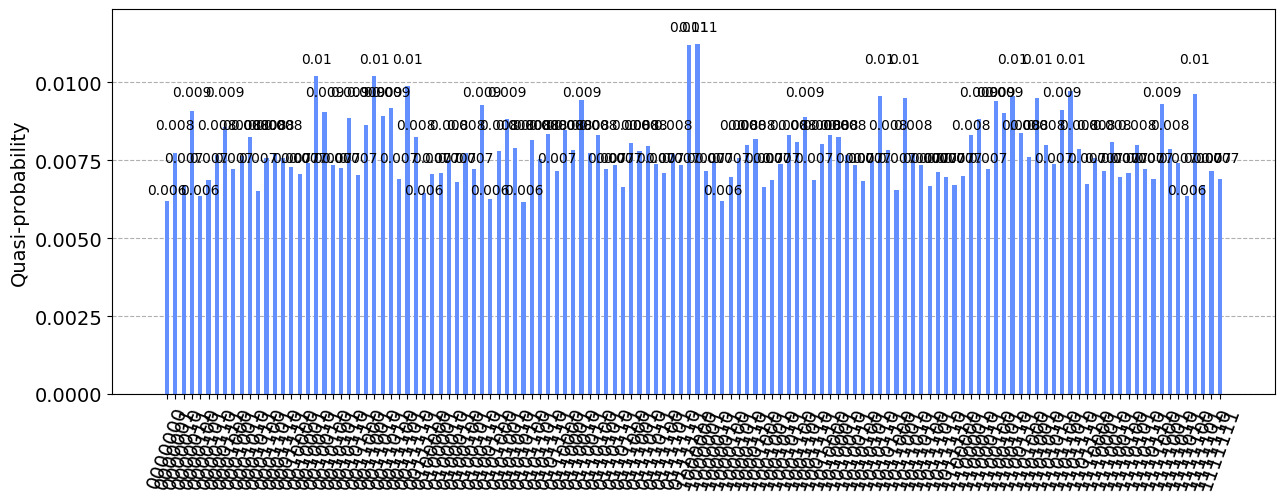

In [210]:
plot_distribution(samp_dist, figsize=(15, 5))

In [211]:
plot_samples(samp_dist)
#print(samp_dist)

The most probable bit-strings, up to finite-sampling deviations, encode the solution.  Here we see that `00001` and `11110` are found, and are indeed correct.  There are two solutions because the labeling of the two partitions with `'0'` or `'1'` is arbitrary.


In [212]:
# Reverse 11110 to convert quantum result to classical solution
solution = [0,1,0,0,1][::-1]

colors = ["r" if solution[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

IndexError: list index out of range